In [1]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

from IPython.display import display, Audio

In [2]:
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

In [3]:
from mean_shift import mean_shift, make_gaussian_kernel, label_points, get_seeds

# Mean-Shift Clustering

In [4]:
data = np.loadtxt('cluster-data.csv', delimiter=',')

In [5]:
%timeit centroids = mean_shift(data, make_gaussian_kernel(2)); groups = label_points(centroids, data)

10.1 ms ± 234 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


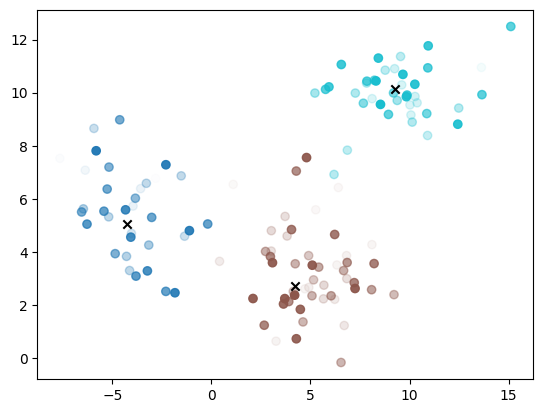

In [6]:
weights = np.random.random(len(data))  # just for demo purposes we randomly weight the points
centroids = mean_shift(data, make_gaussian_kernel([1, 2], weights))
groups = label_points(centroids, data)
plt.scatter(data[:, 0], data[:, 1], alpha=weights, c=groups, cmap='tab10')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x')

In [7]:
# Load the full dataset
data_full = np.loadtxt('alpha-delta.csv', delimiter=',').T
weights_full = np.loadtxt('weights.csv', delimiter=',')

weights_full.mean(), np.median(weights_full), (weights_full > 0.05).mean()

(0.9199692816737458, 0.006181090316266053, 0.311312134502924)

(array([0, 1, 2, 3, 4]), array([1883, 1403, 1909, 2063, 1565]))

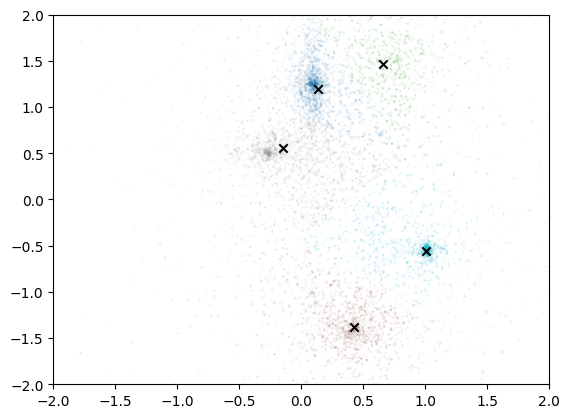

In [16]:
threshold = 0.5  # the higher the value, the faster it will run, but it may also start moving the cluster centers around
x_limit, y_limit = 2, 2  # for display purposes, we could also use this to limit the data but that may end up causing problems with real data
bandwidth = 0.2  # can also be a sequence of floats, one for each dimension
min_count = 1  # the minimum number of points in a bin to consider it a seed
top_n = 25  # the number of bins to consider, if None then all bins are considered

# Only use values that are greater than a threshold
#mask = (abs(data_full[:, 0]) < x_limit) & (abs(data_full[:, 1]) < y_limit)
mask = weights_full > threshold
data = data_full[mask]
weights = weights_full[mask]

# Transform the weights for display purposes
weights_log = np.log(weights.ravel())
weights_log = (weights_log - np.min(weights_log)) / (np.max(weights_log) - np.min(weights_log)) / 5

# Compute the mean-shift centroids
seeds = get_seeds(data, bandwidth, top_n=top_n, min_count=min_count)
centroids = mean_shift(data,
                       make_gaussian_kernel(bandwidth, weights),
                       seeds=seeds, bandwidth=np.min(bandwidth))

# Compute the group assignments / clusters
groups = label_points(centroids, data)

# Plot the results
plt.scatter(data[:, 0], data[:, 1], alpha=weights_log, c=groups, s=1, cmap='tab10')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x')
plt.xlim(-x_limit, x_limit)
plt.ylim(-y_limit, y_limit)

# Count the number of points in each cluster
np.unique(groups, return_counts=True)

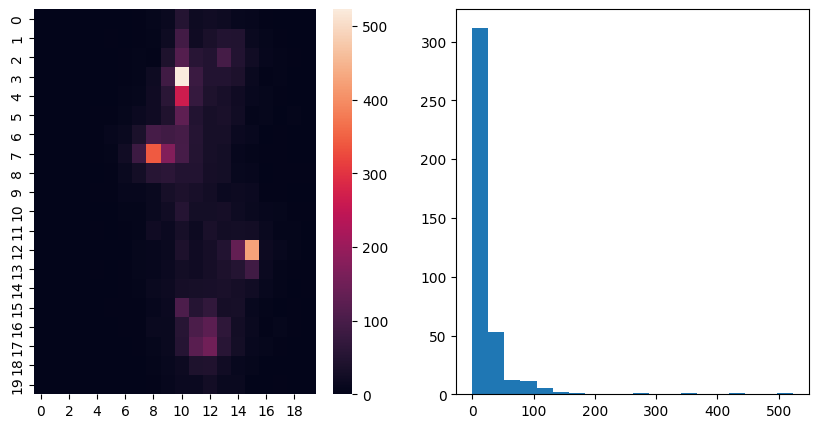

In [17]:
# Histogram of the data taking into account the bandwidth
# Note: this does not take into account the weights (the get_seeds function does not either)
import seaborn as sns
mask_view = (abs(data[:, 0]) < x_limit) & (abs(data[:, 1]) < y_limit)
data_view = data[mask_view]
#weights_view = weights[mask_view]
H, xedges, yedges = np.histogram2d(data_view[:, 0], data_view[:, 1],
                                   bins=np.around(np.array([x_limit, y_limit])*2/bandwidth).astype(int),)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(H.T[::-1]);
plt.subplot(1, 2, 2)
plt.hist(H.ravel(), 20);

Text(0, 0.5, 'Delay ($\\delta$)')

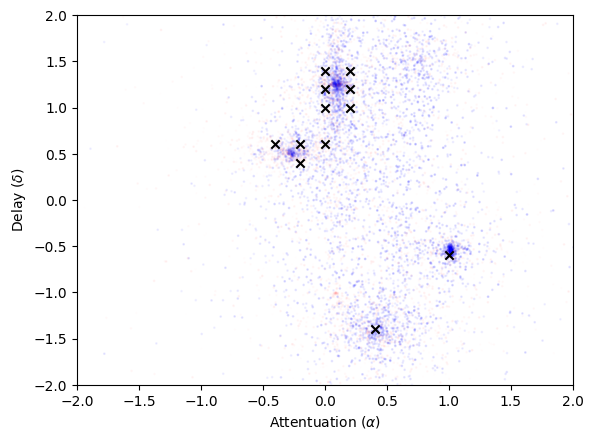

In [20]:
seeds = get_seeds(data, bandwidth, min_count=100, top_n=25)
below = weights < np.median(weights) #  weights.mean()
plt.scatter(data[below][:, 0], data[below][:, 1], alpha=weights_log[below], s=1, c='red')
plt.scatter(data[~below][:, 0], data[~below][:, 1], alpha=weights_log[~below], s=1, c='blue')
plt.scatter(seeds[:, 0], seeds[:, 1], c='black', marker='x')
plt.xlim(-x_limit, x_limit)
plt.xlabel('Attentuation ($\\alpha$)')
plt.ylim(-y_limit, y_limit)
plt.ylabel('Delay ($\\delta$)')

In [11]:
seeds = get_seeds(data, bandwidth, min_count=min_count, top_n=top_n)
kernel = make_gaussian_kernel(bandwidth, weights)
bandwidth_min = np.min(bandwidth)
%timeit centroids = mean_shift(data, kernel, seeds=seeds, bandwidth=bandwidth_min)

115 ms ± 7.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Audio Processing

In [36]:
from duet_ms import DuetMS

In [37]:
fs, x = sp.io.wavfile.read('x.wav')  # 'rendered_audio/tp_-60_cough_+30.wav'  #'binaural_simulated.wav'
x = x.T
x = x[:, :fs*5]  # at most 5 seconds
if fs != 16000:
    x = sp.signal.resample(x, 16000 * x.shape[1] // fs, axis=1)
    fs = 16000
if x.shape[1] % 128 != 0:
    x = x[:, :x.shape[1] - (x.shape[1] % 128)]  # make it a multiple of 128

#x = x[:, :16384]

display(Audio(x, rate=fs))

In [38]:
duet = DuetMS(fs, threshold=0.5, attenuation_max=3.6, delay_max=3.6)

In [69]:
res = [duet.start(x[:, :fs])]
def run_online(x, res):
    off = fs
    inc = 10*128
    while off < x.shape[1]:
        res.append(duet.update(x[:, off:off+inc], False))
        off += inc

In [67]:
%%time
run_online(x, res)

CPU times: user 1.49 s, sys: 2.25 ms, total: 1.49 s
Wall time: 1.49 s


In [71]:
%lprun -f duet.update -f duet._find_peaks -f mean_shift run_online(x, res)

Timer unit: 1e-09 s

Total time: 0.917186 s
File: /home/jbush/HONORS/duet_base.py
Function: update at line 188

Line #      Hits         Time  Per Hit   % Time  Line Contents
   188                                               def update(self, x: ndarray, return_full: bool = True) -> ndarray:
   189                                                   """
   190                                                   Update the online DUET algorithm with the new audio signal. This must
   191                                                   be called after start().
   192                                                   
   193                                                   Arguments
   194                                                   ---------
   195                                                   x : ndarray
   196                                                       The input audio signal, has shape (n_channels, n_samples). The
   197                                            

In [ ]:
# when inc = 5*128 -> 1500/78 -> 20 ms to process each 40 ms chunk of audio
# when inc = 10*128 -> 900/39 -> 23 ms to process each 80 ms chunk of audio
# when inc = 20*128 -> 430/20 -> 21.5 ms to process each 160 ms chunk of audio
# the vast majority of the time is in mean_shift, seems to take the same time regardless of the amount of data...
# possibly the threshold needs to scale with the amount of data?
len(res)-1

20

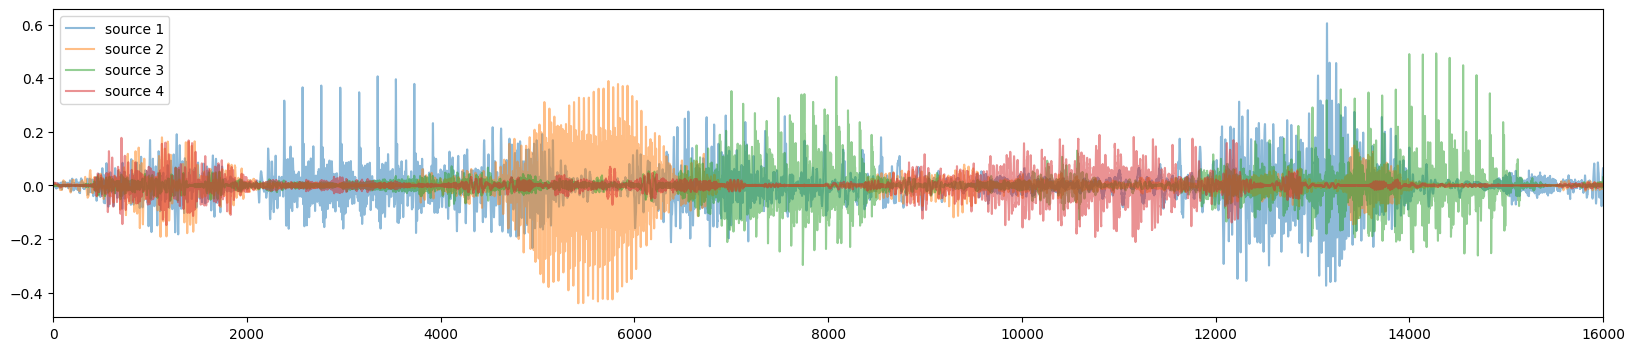

In [45]:
plt.figure(figsize=(20, 4))
for i in range(len(res1)):
    plt.plot(res1[i], alpha=0.5, label=f'source {i+1}')
    display(Audio(res1[i], rate=fs))
plt.xlim(0, res1.shape[1])
plt.legend();

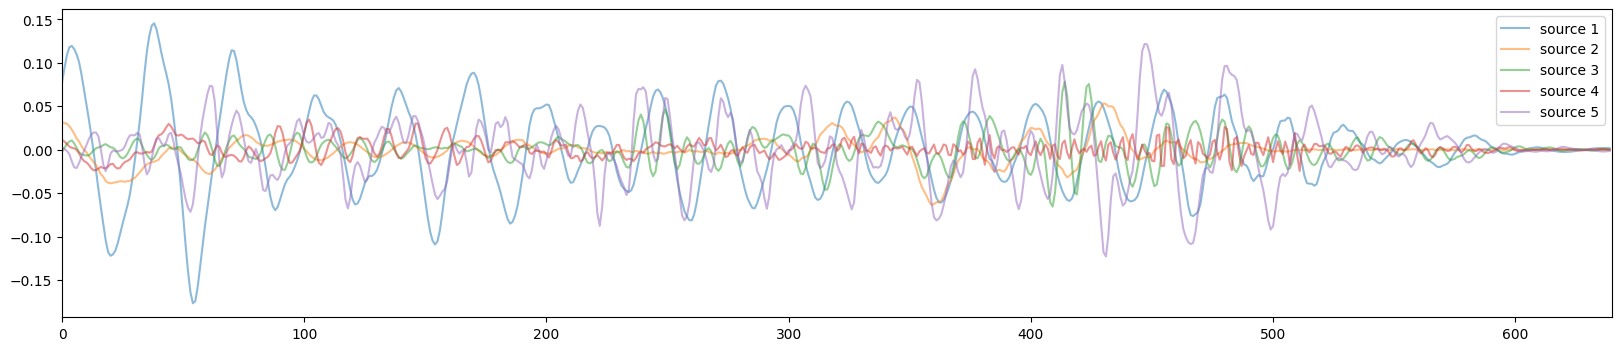

In [46]:
plt.figure(figsize=(20, 4))
for i in range(len(res2)):
    plt.plot(res2[i], alpha=0.5, label=f'source {i+1}')
    display(Audio(res2[i], rate=fs))
plt.xlim(0, res2.shape[1])
plt.legend();

In [34]:
#%%timeit  # 85 ms
duet = DuetMS(fs, threshold=0.5, attenuation_max=3.6, delay_max=3.6)
xx = duet._normalize_data(x)
tf = duet._construct_spectrogram(xx)  # 17%
alpha, delta = duet._compute_attenuation_and_delay(tf)  # 1%
tf_weights = duet._compute_weights(tf)


points, weights = duet._get_points(tf_weights, alpha, delta)  # 0.7%
seeds = get_seeds(points, duet.bandwidth, duet.min_bin_count, duet.seed_count, duet._bounds(1))  # 0.7%
if seeds.size == 0: raise ValueError("no seeds found")
kernel = make_gaussian_kernel(duet.bandwidth, weights)
centroids = mean_shift(points, kernel, seeds, np.min(duet.bandwidth), convergence_tol=duet.convergence_tol)  # 37%
sym_atn_peaks, delay_peaks = centroids[:, 0], centroids[:, 1]


atn_peaks = duet._convert_sym_to_atn(sym_atn_peaks)
best, sources = duet._compute_sources(tf, atn_peaks, delay_peaks)
sources = duet._demix(best, sources)
est = duet._convert_to_time_domain(sources)[:, :xx.shape[-1]]  # 21%

In [14]:
n_tf = tf_weights.shape[-2] * tf_weights.shape[-1]
if tf_weights.ndim == 3:
    a = alpha.reshape(-1, n_tf)
    d = delta.reshape(-1, n_tf)
    w = tf_weights.reshape(-1, n_tf)
else:
    a = alpha.reshape(1, n_tf)
    d = delta.reshape(1, n_tf)
    w = tf_weights.reshape(1, n_tf)


In [18]:
np.concatenate((a, d)).shape

(2, 65536)

In [35]:
atn_peaks, delay_peaks

(array([1.06966441, 0.92783967, 1.23433172, 1.38214951, 1.6227656 ]),
 array([ 1.19940312,  0.55985108, -1.37829474,  1.46215909, -0.55250193]))

In [252]:
atn_peaks, delay_peaks

(array([1.06812699, 0.92085753, 1.23704216, 1.62288038]),
 array([ 1.20299473,  0.55406626, -1.38130036, -0.55228633]))

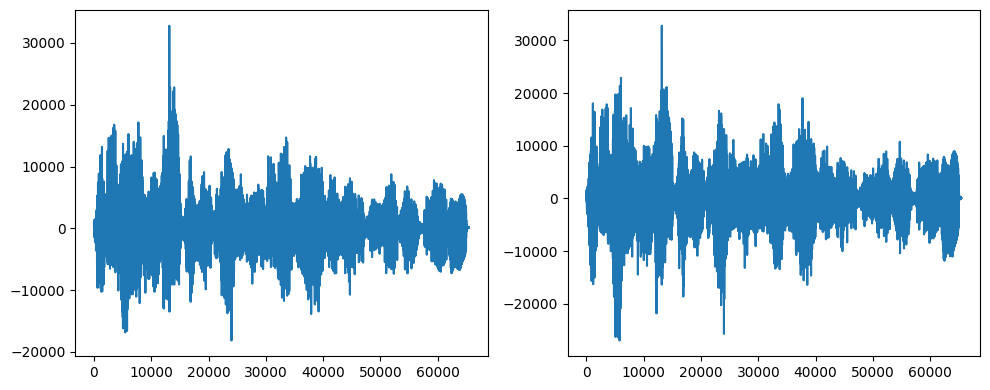

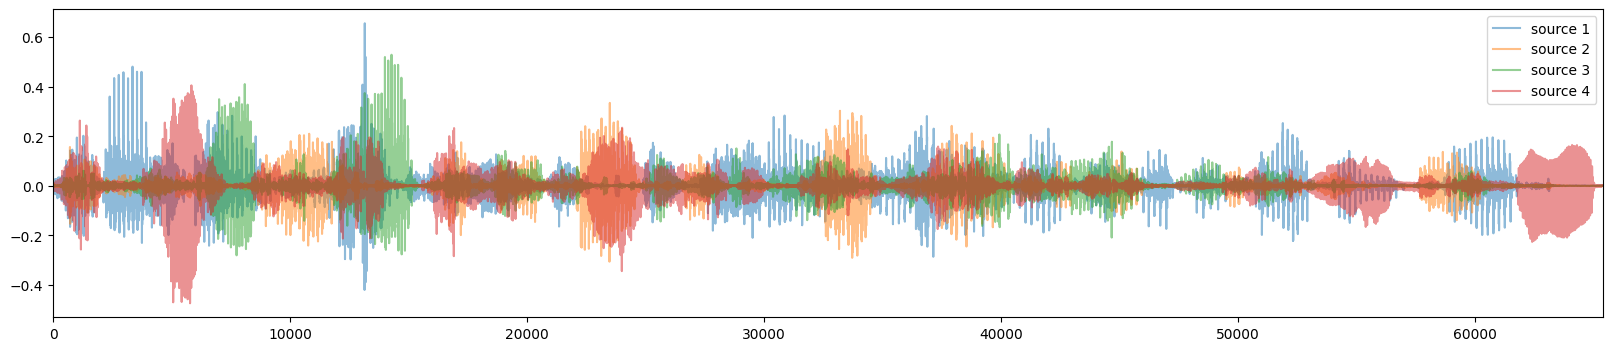

In [153]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x[0])
plt.subplot(1, 2, 2)
plt.plot(x[1])
plt.tight_layout()
#display(Audio(x, rate=fs))

plt.figure(figsize=(20, 4))
for i in range(len(est)):
    plt.plot(est[i], alpha=0.5, label=f'source {i+1}')
    display(Audio(est[i], rate=fs))
plt.xlim(0, est.shape[1])
plt.legend();

In [262]:
%lprun -f duet.run -f duet._find_peaks -f duet._get_points -f get_seeds -f mean_shift duet(x);

Timer unit: 1e-09 s

Total time: 0.12104 s
File: /home/jbush/HONORS/duet_base.py
Function: run at line 347

Line #      Hits         Time  Per Hit   % Time  Line Contents
   347                                               def run(self, x: np.ndarray, **kwargs) -> np.ndarray:
   348                                                   """
   349                                                   Run the DUET algorithm on the input audio signal.
   350                                           
   351                                                   Arguments
   352                                                   ---------
   353                                                   x : ndarray
   354                                                       The input audio signal, has shape (n_channels, n_samples).
   355                                                   kwargs : dict
   356                                                       Additional arguments to pass to the peak finding 

In [332]:
a_best, a_sources = duet._compute_sources(tf, atn_peaks, delay_peaks)
b_best, b_sources = duet._compute_sources_multi(tf, atn_peaks[None, ...], delay_peaks[None, ...])

(1, 4, 1, 1) (1, 4, 1, 1) (1, 1, 128, 1) (2, 1, 128, 512)


In [333]:
print((a_best == 0).sum(), (a_best == 1).sum(), (a_best == 2).sum(), (a_best == 3).sum())
print((b_best == 1).sum(), (b_best == 2).sum(), (b_best == 3).sum(), (b_best == 0).sum())
(a_best == b_best).mean()

19784 15637 12159 17956
22413 11842 12202 19079


0.7063446044921875

<Axes: >

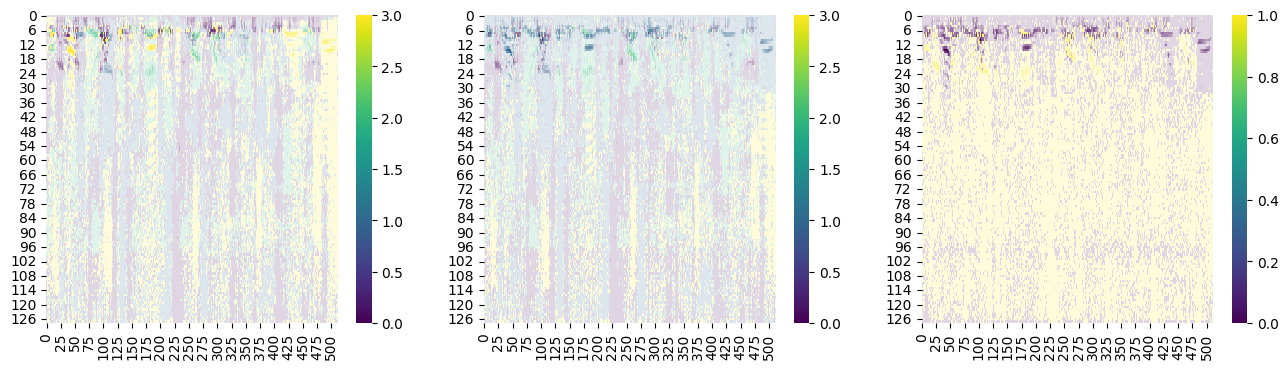

In [338]:
opacity = np.log(tf_weights).clip(min=1)
opacity = opacity / opacity.max()
#opacity = 1
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
sns.heatmap(a_best, cmap='viridis', alpha=opacity)
plt.subplot(1, 3, 2)
sns.heatmap(b_best, cmap='viridis', alpha=opacity)
plt.subplot(1, 3, 3)
sns.heatmap(a_best == b_best, cmap='viridis', alpha=opacity)

In [339]:
a_sources.shape, b_sources.shape

((4, 128, 512), (4, 128, 512))

<Axes: >

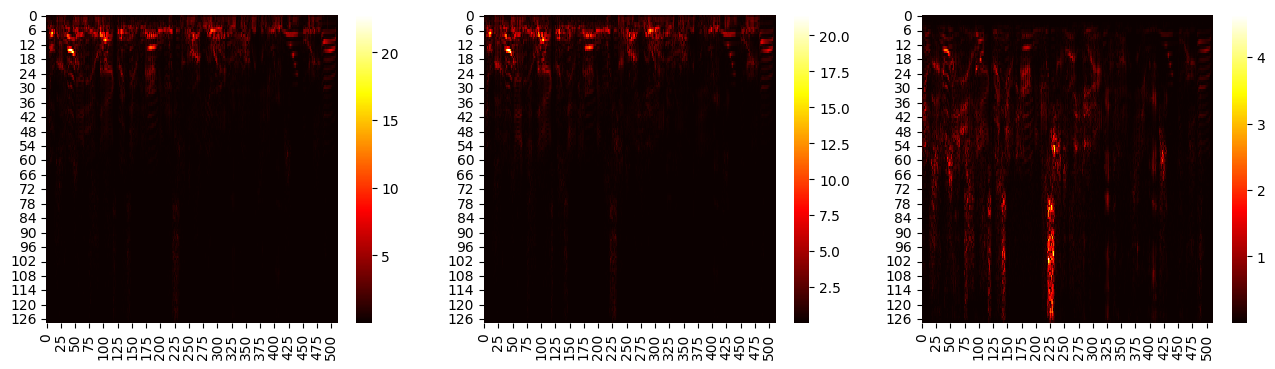

In [340]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
sns.heatmap(np.abs(a_sources[0]), cmap='hot') # , norm=LogNorm()
plt.subplot(1, 3, 2)
sns.heatmap(np.abs(b_sources[0]), cmap='hot')
plt.subplot(1, 3, 3)
sns.heatmap(np.abs(a_sources[0] - b_sources[0]), cmap='hot')